In [116]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re


import string
warnings.filterwarnings('ignore')

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [3]:
train.head()
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
52508,8c742dd859f917db,Fits in with portrait of previous governors,0,0,0,0,0,0
67636,b4f8df6882520554,Osteosarcoma Risk \nI have edited the statemen...,0,0,0,0,0,0
83732,e019621b85030db3,especially sensative subjects that might spark...,0,0,0,0,0,0
65120,ae3ce4aca87a1685,H index \nRe: Wikipedia:Articles_for_deletion/...,0,0,0,0,0,0
129877,b6bdb2ef2ccedacd,Thanks for making your biases clear.Please don...,0,0,0,0,0,0


In [4]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [84]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [6]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
unlabelled_in_all = train[(train['toxic']!=1) & (train['severe_toxic']!=1) & (train['obscene']!=1) & (train['threat']!=1) & (train['insult']!=1) & (train['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train)*100)

Percentage of unlabelled comments is  89.83211235124176


In [10]:

dd = train['toxic']+train['severe_toxic']+train['obscene']+train['threat']+train['insult']+train['identity_hate']
print('중복된 라벨을 갖는 비율 : {}'.format(sum(dd>2)/len(train)*100))
print("레벨을 갖는 것들 중 중복된 라벨을 갖는 비율 : {}".format((sum(dd>2)/len(train))/((len(train)-len(unlabelled_in_all))/len(train))*100))

중복된 라벨을 갖는 비율 : 4.00135362941888
레벨을 갖는 것들 중 중복된 라벨을 갖는 비율 : 39.35285053929121


In [11]:
print('Total rows in test is {}'.format(len(test)))
print('Total rows in train is {}'.format(len(train)))
print(train[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [12]:
#댓글 글자 수
train['char_length'] = train['comment_text'].apply(lambda x: len(str(x)))
#test['char_length'] = test['comment_text'].apply(lambda x: len(str(x)))

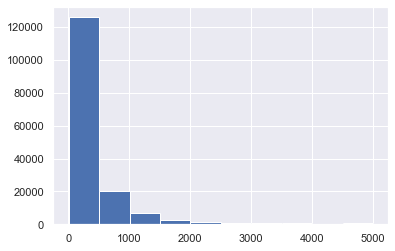

In [13]:
sns.set()
train['char_length'].hist()
plt.show()

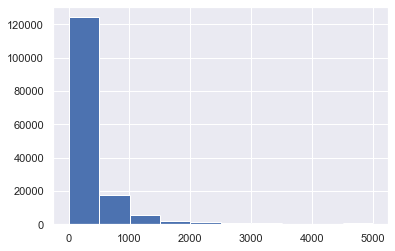

In [48]:
plt.figure()
plt.hist(test['char_length'])
plt.show()

In [14]:
#라벨 데이터만 가지고 시각화
data = train[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

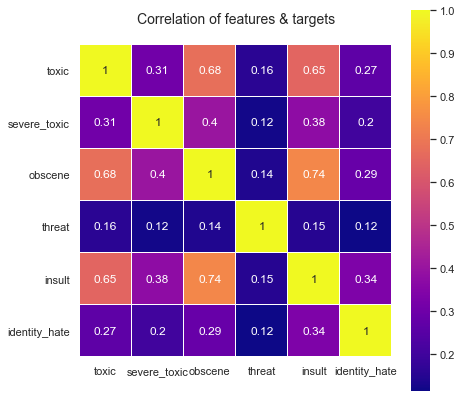

In [15]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [18]:
data = train[['obscene','insult','toxic','severe_toxic','identity_hate','threat']]

obscene, insult, toxic 이 같이 라벨링 될 가능성이 높다.


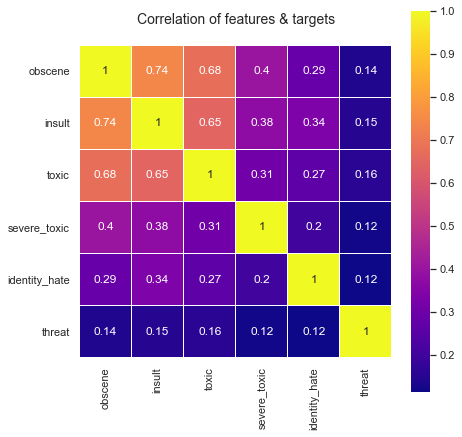

In [20]:
data = train[['obscene','insult','toxic','severe_toxic','identity_hate','threat']]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

print('obscene, insult, toxic 이 같이 라벨링 될 가능성이 높다.')

In [21]:
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [22]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

In [23]:
train = train.drop('char_length',axis=1)

In [24]:
X = train.comment_text
test_X = test.comment_text

In [25]:
print(X.shape, test_X.shape)

(159571,) (153164,)


In [12]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [27]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3160097 stored elements in Compressed Sparse Row format>

In [28]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm


<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2641821 stored elements in Compressed Sparse Row format>

In [34]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv('./sample_submission.csv')

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing toxic
Training accuracy is 0.9639282827080109
... Processing severe_toxic
Training accuracy is 0.9921476960099266
... Processing obscene
Training accuracy is 0.9834932412531099
... Processing threat
Training accuracy is 0.9981011587318498
... Processing insult
Training accuracy is 0.9754717335856766
... Processing identity_hate
Training accuracy is 0.9939086676150428


In [35]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999940,0.525362,0.999963,0.084980,0.966098,0.347299
1,0000247867823ef7,0.002436,0.000377,0.000364,0.000317,0.002642,0.000563
2,00013b17ad220c46,0.010777,0.000104,0.002292,0.000034,0.007244,0.001394
3,00017563c3f7919a,0.000693,0.001695,0.001197,0.000079,0.001621,0.000036
4,00017695ad8997eb,0.035272,0.000642,0.001939,0.000804,0.004756,0.000488


In [36]:
# generate submission file
submission_binary.to_csv('submission_binary.csv',index=False)

In [37]:
# create submission file
submission_chains = pd.read_csv('./sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [40]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing toxic
Training Accuracy is 0.9639282827080109
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing severe_toxic
Training Accuracy is 0.9925801054076242
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing obscene
Training Accuracy is 0.9853419480983386
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing threat
Training Accuracy is 0.9984144988751089
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing insult
Training Accuracy is 0.9823714835402423
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing identity_hate
Training Accuracy is 0.995462834725608
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


In [41]:
submission_chains.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999940,4.709348e-01,0.999734,0.146071,0.860471,0.453215
1,0000247867823ef7,0.002436,5.003495e-07,0.000224,0.000076,0.002881,0.000220
2,00013b17ad220c46,0.010777,1.837373e-07,0.000593,0.000011,0.002506,0.000654
3,00017563c3f7919a,0.000693,7.108728e-06,0.001461,0.000045,0.000689,0.000004
4,00017695ad8997eb,0.035272,3.628380e-07,0.000406,0.000164,0.001197,0.000063


In [42]:
# generate submission file
submission_chains.to_csv('submission_chains.csv', index=False)

In [43]:
# create submission file
submission_combined = pd.read_csv('./sample_submission.csv')

In [44]:
# corr_targets = ['obscene','insult','toxic']
for label in cols_target:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])


In [45]:
submission_combined.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999940,0.498149,0.999848,0.115525,0.913285,0.400257
1,0000247867823ef7,0.002436,0.000189,0.000294,0.000196,0.002762,0.000391
2,00013b17ad220c46,0.010777,0.000052,0.001442,0.000022,0.004875,0.001024
3,00017563c3f7919a,0.000693,0.000851,0.001329,0.000062,0.001155,0.000020
4,00017695ad8997eb,0.035272,0.000321,0.001172,0.000484,0.002977,0.000275


In [46]:
# generate submission file
submission_combined.to_csv('submission_combined.csv', index=False)

# 연습

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

import xgboost as xgb
import gc


train_mes, valid_mes, train_l, valid_l = train_test_split(train['comment_text'],train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=2)


import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

transform_com = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1).fit(train['comment_text'])
'''comments_train = transform_com.transform(train['comment_text'])'''
comments_train = transform_com.transform(train_mes)
comments_valid = transform_com.transform(valid_mes)
comments_test = transform_com.transform(test['comment_text'])
gc.collect()

train_mes = pd.DataFrame(train_mes)
valid_mes = pd.DataFrame(valid_mes)

data = [train_mes, valid_mes, test]
train_mes = scipy.sparse.csr_matrix(train_mes[col].values)
valid_mes = scipy.sparse.csr_matrix(valid_mes[col].values)
test = scipy.sparse.csr_matrix(test[col].values)


comments_train = scipy.sparse.hstack([train_mes.tocsr(),comments_train.tocsr()])
comments_valid = scipy.sparse.hstack([valid_mes,comments_valid])
comments_test = scipy.sparse.hstack([test,comments_test])




import xgboost as xgb


def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    return model    

col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = np.zeros((test.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB(comments_train, train_l[j], comments_valid,valid_l[j])
    preds[:,i] = model.predict(xgb.DMatrix(comments_test), ntree_limit = model.best_ntree_limit)
    gc.collect()

subm = pd.read_csv('../input/sample_submission.csv')    
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = col)], axis=1)
submission.to_csv('xgb.csv', index=False)
    

In [107]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Total comments =  159571
Total clean comments =  143346
Total tags = 35098
Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


obscene, insult, toxic 이 같이 라벨링 될 가능성이 높다.


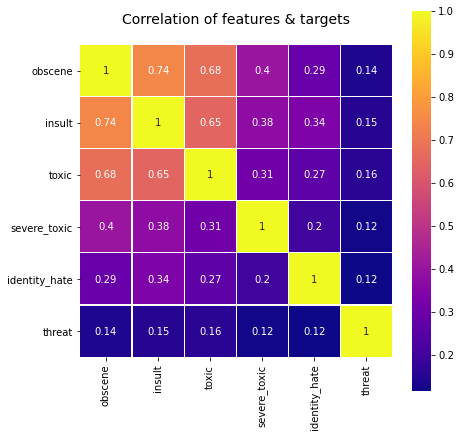

In [111]:
data = train[['obscene','insult','toxic','severe_toxic','identity_hate','threat']]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

print('obscene, insult, toxic 이 같이 라벨링 될 가능성이 높다.')

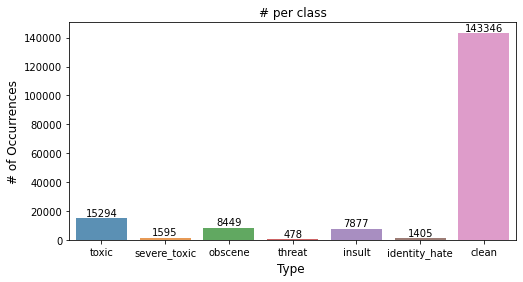

In [108]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

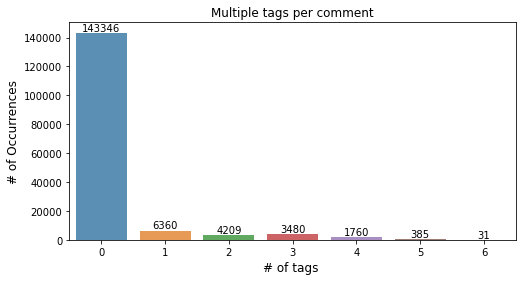

In [110]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


In [112]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

# comment_text 에서 파생변수 

In [119]:

#댓글에 포함된 문장 수:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#단어수:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique 단어수
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#글자수
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#문장부호 수
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#스톱워드 수 
#df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#단어의 글자수의 평균
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [120]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [121]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [124]:
#ip
train['ip']=train["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
train['count_ip']=train["ip"].apply(lambda x: len(x))

#links
train['link']=train["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
train['count_links']=train["link"].apply(lambda x: len(x))

# Leaky Ip
cv = CountVectorizer()
train_count_feats_ip = cv.fit_transform(train["ip"].apply(lambda x : str(x)))





#ip
test['ip']=test["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
test['count_ip']=test["ip"].apply(lambda x: len(x))

#links
test['link']=test["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
test['count_links']=test["link"].apply(lambda x: len(x))

# Leaky Ip
cv = CountVectorizer()
test_count_feats_ip = cv.fit_transform(test["ip"].apply(lambda x : str(x)))


In [125]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,ip,count_ip,link,count_links
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,[89.205.38.27],1,[],0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,[],0,[],0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,[],0,[],0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,[],0,[],0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,[],0,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,[],0,[],0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,[128.61.19.93],1,[],0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,[],0,[],0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,[],0,[],0


In [17]:
#Unique word count
train['count_unique_word']=train["comment_text"].apply(lambda x: len(set(str(x).split())))
train['count_word']=train["comment_text"].apply(lambda x: len(str(x).split()))

train['word_unique_percent']=train['count_unique_word']*100/train['count_word']


#Unique word count
test['count_unique_word']=test["comment_text"].apply(lambda x: len(set(str(x).split())))
test['count_word']=test["comment_text"].apply(lambda x: len(str(x).split()))

test['word_unique_percent']=test['count_unique_word']*100/test['count_word']

In [18]:
#spammers - comments with less than 40% unique words
spammers=train[train['word_unique_percent']<30]

plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [19]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [20]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [21]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [38]:
list_tokenized_train[:1]

#토크나이저를 통해 토큰화를 한 후 첫번째 댓글이 어떻게 변화하였는지를 볼 수 있습니다.
#각 단어에 인덱스가 부여되었고 단어대신 숫자 데이터로 변경된 것을 볼 수 있습니다. 
#각 댓글마다 길이가 다르므로 데이터의 길이를 맞춰주기 위해 짧은 댓글들에 0을 추가하여 padding을 할 수 있습니다.
#그런데 이때 길이가 가장 긴 댓글을 기준으로하면 짧은 댓글은 0이 너무 과도하게 많습니다. 그래서 길이는 200으로 맞추었습니다

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

In [23]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)


In [24]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
#각 댓글에 단어 수

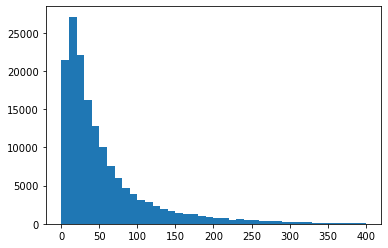

In [39]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()
#단어 수가 대부분 100개 이하인 것으로 보인다.
maxlen = 100

In [26]:
inp = Input(shape=(maxlen, )) #maxlen=100 as defined earlier
#input은 위에서 지정한대로 각 댓글당 100개의 단어를 넣는다. 

In [27]:
#embedding은 의미상 가까운 단어가 숫자상 가까운 위치에 놓이도록 조정하는 과정이다. 

#embed 사이즈를 128로 지정해주었다.
embed_size = 128
x = Embedding(max_features, embed_size)(inp)


 <iframe src="https://www.kaggle.com/embed/sbongo/for-beginners-tackling-toxic-using-keras?cellId=36&cellIds=36&hide=output&kernelSessionId=2226937" height="300" style="margin: "0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="[For Beginners] Tackling Toxic Using Keras"></iframe>

In [ ]:
#위의(None, 100, 128)  3차원 TENSOR데이터를 LSTM후  (None, 100, 60) 로 나올 수 있게 지정하였다.

In [28]:

x = LSTM(60, return_sequences=True,name='lstm_layer')(x)


In [29]:
x = GlobalMaxPool1D()(x)
#2차원데이터를 1차원으로 축소한다.

In [30]:
x = Dropout(0.1)(x)
#과적합을 줄이기 위해 인공신경망 내의 계산을 일부 줄인다. -> 10프로의 layout을 줄임

In [31]:
x = Dense(50, activation="relu")(x)
#Relu 함수로 50차원의 결과를 얻음

In [32]:
x = Dropout(0.1)(x)

In [33]:
x = Dense(6, activation="sigmoid")(x)
#sigmoid함수로 우리가 예측해야 할 차원의 수인 6개의 차원을 얻음

In [34]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [35]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 845s 6ms/step - loss: 0.0695 - accuracy: 0.9774 - val_loss: 0.0497 - val_accuracy: 0.9817
Epoch 2/2
143613/143613 [==============================] - 1663s 12ms/step - loss: 0.0451 - accuracy: 0.9831 - val_loss: 0.0467 - val_accuracy: 0.9826


In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [37]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape
#print layer_output to see the actual data

(1, 200, 60)

# 감성분석 이진분류

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , roc_auc_score

In [78]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [ ]:
unlabelled_in_all_train = train[(train['toxic']!=1) & (train['severe_toxic']!=1) & (train['obscene']!=1) & (train['threat']!=1) & (train['insult']!=1) & (train['identity_hate']!=1)].index
unlabelled_in_all

In [79]:

train['sentiment'] = 1
train['sentiment'].iloc[unlabelled_in_all]=0
train['sentiment'].describe()

count    159571.000000
mean          0.101679
std           0.302226
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: sentiment, dtype: float64

In [81]:
train['sentiment'][train['sentiment']==1]

6         1
12        1
16        1
42        1
43        1
         ..
159494    1
159514    1
159541    1
159546    1
159554    1
Name: sentiment, Length: 16225, dtype: int64

In [ ]:
#sentiment가 0이면 긍정, 1이면 부정

In [88]:
train = train.drop(cols_target,axis=1)
test = test.drop(cols_target,axis=1)

KeyError: "['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate'] not found in axis"

In [89]:
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [90]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

In [91]:
from sklearn.model_selection import train_test_split

In [94]:
class_df = train['sentiment']
feature_df = train.drop(['id','sentiment'],axis = 1, inplace =False)

In [98]:
X_train,X_test,y_train,y_test = train_test_split(feature_df,class_df,test_size=0.3,random_state=156)
X_train.shape , X_test.shape

((111699, 1), (47872, 1))

In [102]:
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english',ngram_range=(1,2))),
                      ('lr_clf',LogisticRegression(C=10))])

pipeline.fit(X_train['comment_text'],y_train)
pred = pipeline.predict(X_test['comment_text'])
pred_probs = pipeline.predict_proba(X_test['comment_text'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test,pred),
                                                roc_auc_score(y_test,pred_probs)))

예측 정확도는 0.9576, ROC-AUC는 0.9434
